In [31]:
# Joe Considine (22344977)
# Caylum Hurley (22356363)

#Does code execute without errors?
#Dataset used: Dataset of images with handritten numbers from 0 to 9 on each one

In [47]:
# Imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

In [33]:
#Setting random seed for reproducibility
np.random.seed(1671)
tf.random.set_seed(1671)

EPOCHS = 5          # How many times the network will look at all training data
BATCH_SIZE = 128      # How many images at a time the network looks at before updating weights
NB_CLASSES = 10       # 10 digits (0–9)
N_HIDDEN = 128        # Number of neurons in hidden layer
VALIDATION_SPLIT=0.2  # 20% of training data used to check performance during training

In [34]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data() # Load MNIST dataset

# x_train is training image to teach the model
# y_train is the label (Correct answer) for the training image
# x_test is testing image (new unseen image) to test the model to see how well it has learned
# y_test is the label (Correct answer) for the testing image

print("Training data shape:", {x_train.shape})
print("Test data shape:", x_test.shape)

Training data shape: {(60000, 28, 28)}
Test data shape: (10000, 28, 28)


In [35]:
# Normalize pixel values to be between 0 and 1 instead of 0 to 255
X_train = x_train / 255
X_test = x_test / 255

#Reshape images to include channel dimension of 28*28*1
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

#Number of output classes 0-9
number_of_classes = 10

In [ ]:
def build_model(input_size=(28,28,1), number_of_classes=10): #Function to build CNN model
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=input_size), #Input 28*28
        
        #Add first convolutional layer. Uses 64 filters of kernel size 3x3 to extract low spatial features like corners and edges
        layers.Conv2D(64, kernel_size= (3,3), activation='relu'), #64 filters of 3*3 size
        layers.BatchNormalization(), #Batch normalization to improve training speed and stability
        layers.MaxPooling2D(pool_size=(2, 2)), #Max pooling to reduce spatial dimensions
    
        #Add second convolutional layer. This time 128 filters of 3x3 kernel size
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu'), #128 filters of 3*3 size
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
    
        #Add third convolutional layer. Now 256 filters of 3x3 size
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu'), #256 filters
        layers.BatchNormalization(),
    
        #Flattten the output for fully connected layers
        layers.Flatten(), #Flatten output to 1D
        layers.Dense(512, activation='relu'), #Fully connected layer with 512 neurons
        layers.Dropout(0.5), #Dropout to prevent overfitting, randomly disable 50% of neurons during training to help generalise any unseen data
        layers.Dense(256, activation='relu'), #Another fully connected layer with 256 neurons
        layers.Dropout(0.5), #Another dropout to prevent the overfitting
    
        #Output layer, using softmax activation for multi-class classification
        layers.Dense(number_of_classes), #10 output classes
        layers.Activation('softmax') #Softmax activation for multi-class classification
    ])
    
    #Compile CNN model
    model.compile(
        optimizer='adam',  # Optimizer adjusts weights during training, chosen for its adaptive learning rate
        loss='sparse_categorical_crossentropy',  # Loss function for multi-class labels
        metrics=['accuracy']  # Track accuracy during training
    )
    return model

model = build_model()
model.summary()  # Print model 
#TODO Fix why below line does not work properly
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)  # Save PNG diagram of the CNN


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 26, 26, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,685,514 (6.43 MB)

 Trainable params: 1,684,618 (6.43 MB)

 Non-trainable params: 896 (3.50 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [37]:
#model.compile(optimizer='SGD',
              #loss='categorical_crossentropy',
              #metrics=['accuracy'])


In [38]:
#model.compile(
    #optimizer='adam',  # Optimizer adjusts weights during training
    #loss='sparse_categorical_crossentropy',  # Loss function for multi-class labels
    #metrics=['accuracy']  # Track accuracy during training
#)

In [39]:
#ReLU used to have non-linearity and to avoid vanishing gradients
# Fits the model on the training data
model_history = model.fit(
    X_train, y_train, # Training data
    batch_size = BATCH_SIZE, # Batch size (128) gives a balance between gradient stability and speed of computation
    epochs = EPOCHS, #Epochs (25) to ensure high  and low loss
    validation_split = VALIDATION_SPLIT, # Validation data to monitor performance, reserves 20% of data to monitor generalisation
    verbose = 1 # Verbosity level (1 = progress bar
)


Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - accuracy: 0.8717 - loss: 0.4416 - val_accuracy: 0.1528 - val_loss: 13.5863
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.9768 - loss: 0.0843 - val_accuracy: 0.9707 - val_loss: 0.1059
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 70s 187ms/step - accuracy: 0.9834 - loss: 0.0585 - val_accuracy: 0.9841 - val_loss: 0.0552
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 71s 189ms/step - accuracy: 0.9859 - loss: 0.0499 - val_accuracy: 0.9852 - val_loss: 0.0555
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 198ms/step - accuracy: 0.9886 - loss: 0.0401 - val_accuracy: 0.9886 - val_loss: 0.0480


In [40]:
#model_history = model.fit(X_train, y_train,
                          #batch_size=BATCH_SIZE,
                          #epochs=EPOCHS,
                          #verbose=1,
                          #validation_split=VALIDATION_SPLIT)


In [41]:
# Evaluate model on test data

test_loss, test_acc = model.evaluate(X_test, y_test, verbose = 0)
print('Test accuracy: ', test_acc) #Print test accuracy
print("Test loss: ", test_loss) #Print test loss

#Get prediction and print with classification report
y_prediction = np.argmax(model.predict(X_test), axis=-1)
print("Classification Report: ")
print(classification_report(y_test, y_prediction, digits=3))

Test accuracy:  0.9883999824523926
Test loss:  0.04740442335605621
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Classification Report: 
              precision    recall  f1-score   support

           0      0.989     0.996     0.992       980
           1      0.991     0.995     0.993      1135
           2      0.990     0.985     0.988      1032
           3      0.985     0.997     0.991      1010
           4      0.995     0.976     0.985       982
           5      0.985     0.989     0.987       892
           6      0.990     0.987     0.989       958
           7      0.986     0.991     0.989      1028
           8      0.995     0.983     0.989       974
           9      0.977     0.984     0.981      1009

    accuracy                          0.988     10000
   macro avg      0.988     0.988     0.988     10000
weighted avg      0.988     0.988     0.988     10000



In [ ]:
#High precison and high recall show a balanced performance for all 10 digits

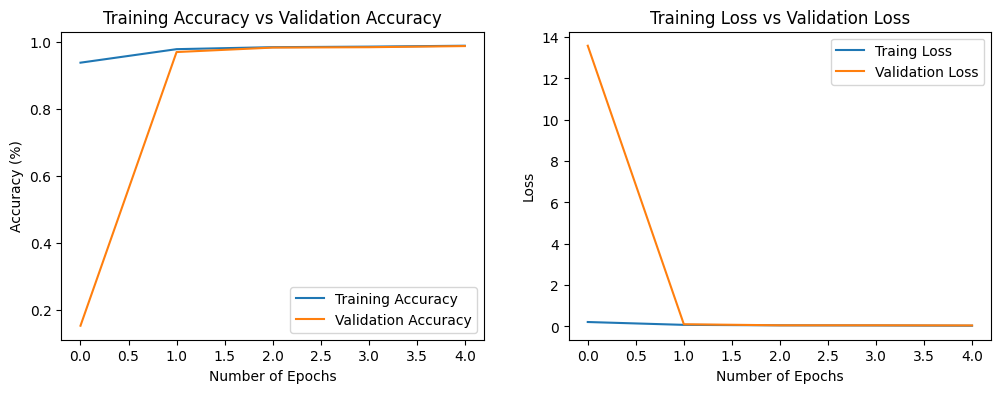

In [42]:
#Plot the training results

plt.figure(figsize=(12,4)) #Creates a figure with size 12x4

plt.subplot(1,2,1) #1 row, 2 columns, first subplot

plt.plot(model_history.history['accuracy'], label = 'Training Accuracy') #Plots Training Accuracy
plt.plot(model_history.history['val_accuracy'], label = 'Validation Accuracy') #Plots Validation Accuracy
plt.title("Training Accuracy vs Validation Accuracy") #Gives the subplot its title
plt.xlabel("Number of Epochs") #Label for x-axis
plt.ylabel("Accuracy (%)") #Label for y-axis
plt.legend() #Adds graphic to show which line is which

plt.subplot(1,2,2) #1 row, 2 columns, second subplot

plt.plot(model_history.history['loss'], label = 'Traing Loss') #Plots Training Loss
plt.plot(model_history.history['val_loss'], label = 'Validation Loss') #Plots Validation Loss
plt.title("Training Loss vs Validation Loss") #Gives the subplot its title
plt.xlabel("Number of Epochs") #Label for x-axis
plt.ylabel("Loss") #Label for y-axis
plt.legend() #Adds graphic to show which line is which

plt.show() #Displays the figure with the two subplots

In [ ]:
#Training and Validation accuracy level out just below 100%. Means we have good generalisation and minimal overfitting
#Training and Validation loss follow similar trend to accuracy curves

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


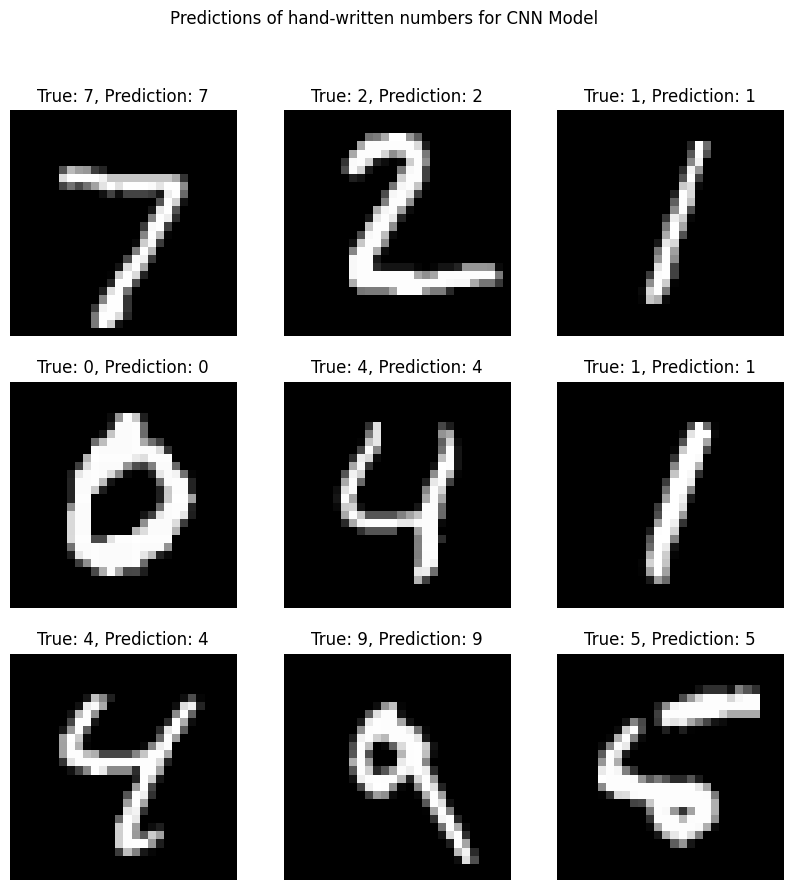

In [43]:
predictions = np.argmax(model.predict(X_test), axis=-1) #Get predicted class labels for test 

#Showing first 9 test images with true and predicted labels
plt.figure(figsize=(10,10)) #Creates a figure of size 10x10
for i in range(9): #Plot first 9 test images with predictions
    plt.subplot(3, 3, i+1) #3 rows, 3 columns
    plt.imshow(X_test[i].reshape(28,28), cmap='gist_grey') #Display image in grayscale
    plt.title(f"True: {y_test[i]}, Prediction: {predictions[i]}") #Title with true and predicted labels
    plt.axis('off') #Turn off axis
    
plt.suptitle("Predictions of hand-written numbers for CNN Model") #Overall title for the figure
plt.show() #Display the figure

In [48]:
#Simulation of k-fold cross-validation

k_fold = KFold(n_splits=3) #3-fold cross-validation
fold = 1 #starting number of folds
for training_index, validation_index in k_fold.split(X_train): #Splits training data into mutliple different folds
    print(f"Training fold: {fold}")
    model = build_model() #builds new model
    model.fit(X_train[training_index], y_train[training_index], #ensures model is trained in the fold
              validation_data = (X_train[validation_index], y_train[validation_index]), #validated with remaining data
              epochs=3, #lowered for sake of speed
              batch_size=128,
              verbose=1
              )
    fold += 1 #goes to next fold and restarts process


Training fold: 1
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 220ms/step - accuracy: 0.8518 - loss: 0.5051 - val_accuracy: 0.1152 - val_loss: 18.0770
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 65s 208ms/step - accuracy: 0.9737 - loss: 0.0968 - val_accuracy: 0.9565 - val_loss: 0.1794
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 215ms/step - accuracy: 0.9810 - loss: 0.0683 - val_accuracy: 0.9850 - val_loss: 0.0501
Training fold: 2
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 69s 208ms/step - accuracy: 0.8588 - loss: 0.4868 - val_accuracy: 0.1141 - val_loss: 31.8782
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 197ms/step - accuracy: 0.9739 - loss: 0.0968 - val_accuracy: 0.9639 - val_loss: 0.1450
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 199ms/step - accuracy: 0.9824 - loss: 0.0609 - val_accuracy: 0.9851 - val_loss: 0.0543
Training fold: 3
Epoch 1/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 74s 213ms/step - accuracy: 0.8547 - loss: 0.4961 - val_accuracy: 0.1089 - val_loss: 27.5377
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━

In [45]:
#We are decreasing the batch size to see how it impacts accuracy, prediction is that it will take longer to train but slightly imporve the accuracy

model_smaller_batch_size = build_model()
model_history_smaller_batch_size = model_smaller_batch_size.fit(
    X_train, y_train,
    epochs = 5,
    batch_size = 64, #decreased batch size
    validation_split = 0.2,
    verbose = 1
)

print("Validation accuracy with batch size of 64: ", model_history_smaller_batch_size.history['val_accuracy'][-1])

Epoch 1/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 106s 134ms/step - accuracy: 0.8773 - loss: 0.4294 - val_accuracy: 0.9808 - val_loss: 0.0725
Epoch 2/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 89s 118ms/step - accuracy: 0.9748 - loss: 0.0981 - val_accuracy: 0.9852 - val_loss: 0.0581
Epoch 3/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 91s 121ms/step - accuracy: 0.9829 - loss: 0.0684 - val_accuracy: 0.9846 - val_loss: 0.0588
Epoch 4/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 89s 119ms/step - accuracy: 0.9836 - loss: 0.0607 - val_accuracy: 0.9837 - val_loss: 0.0699
Epoch 5/5
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 125ms/step - accuracy: 0.9877 - loss: 0.0466 - val_accuracy: 0.9900 - val_loss: 0.0507
Validation accuracy with batch size of 64:  0.9900000095367432


In [ ]:
#As expected, the validation accuracy slightly increases, but computation takes roughly twice as long

In [44]:
#model.save("model_name")